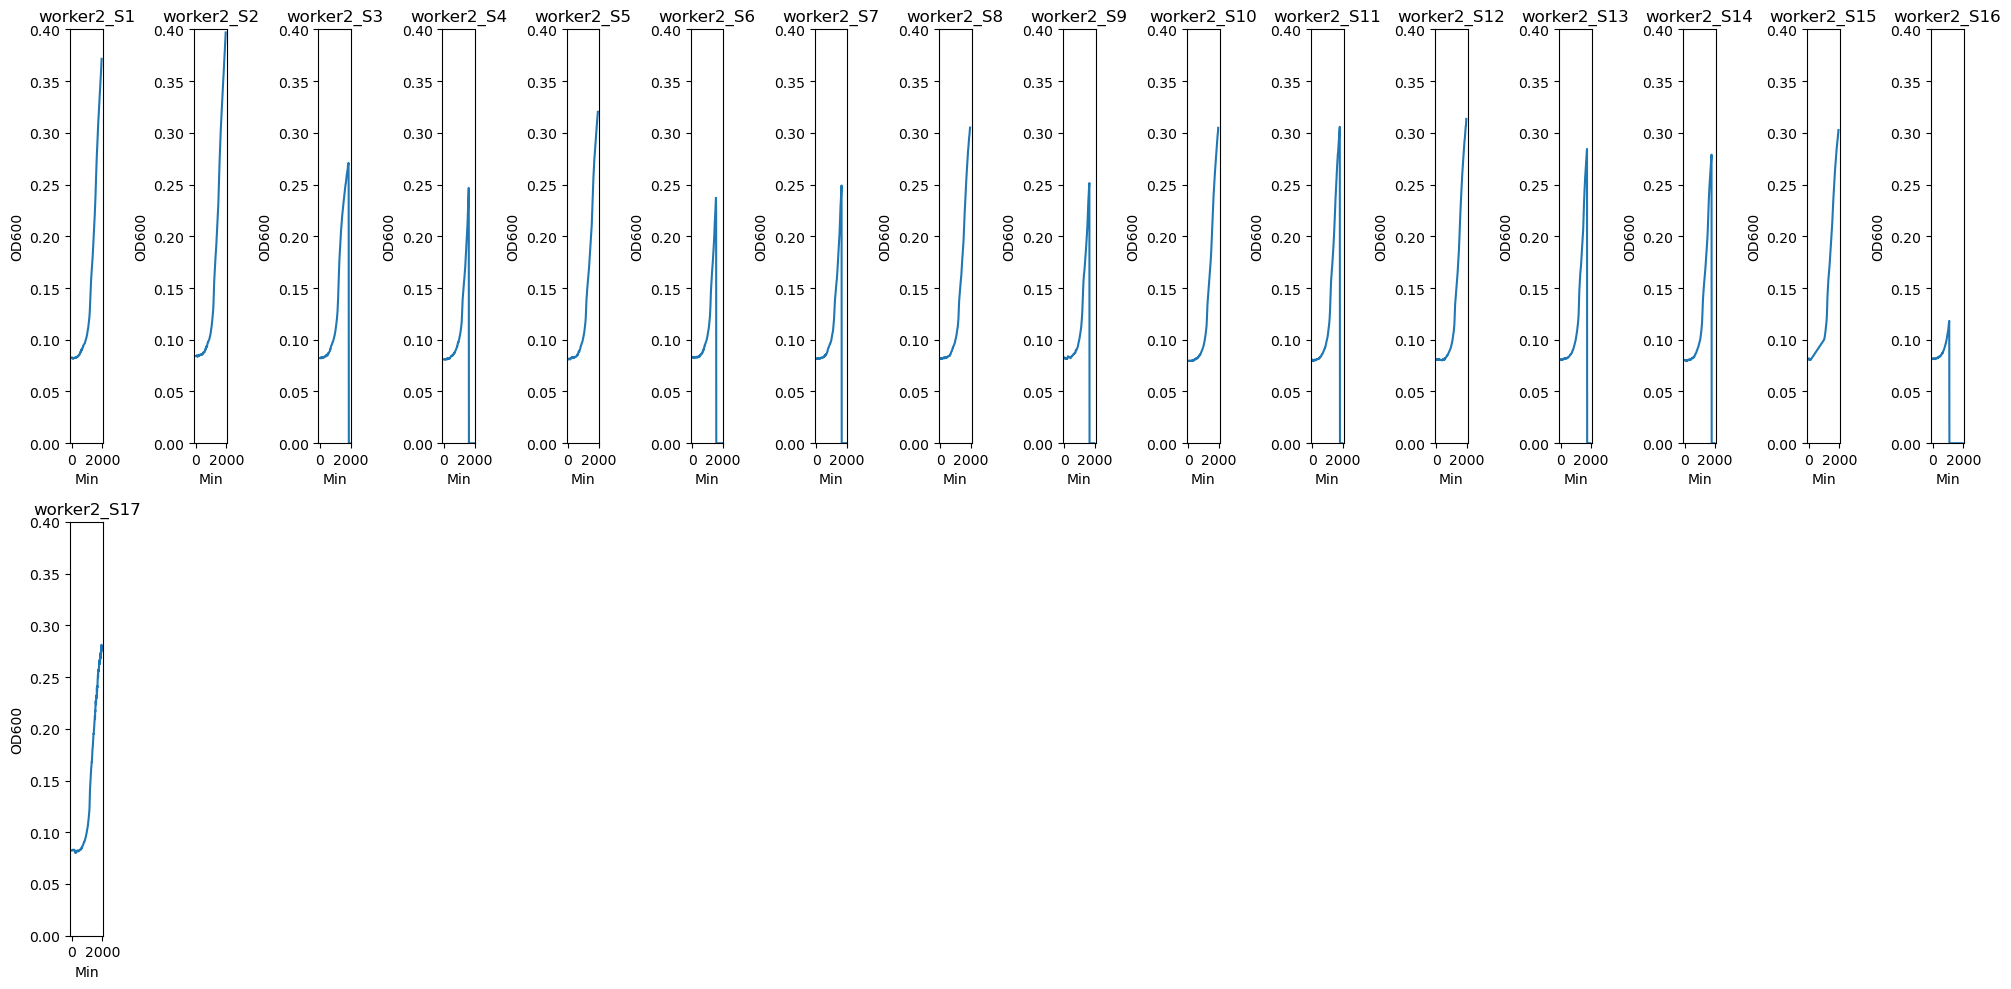

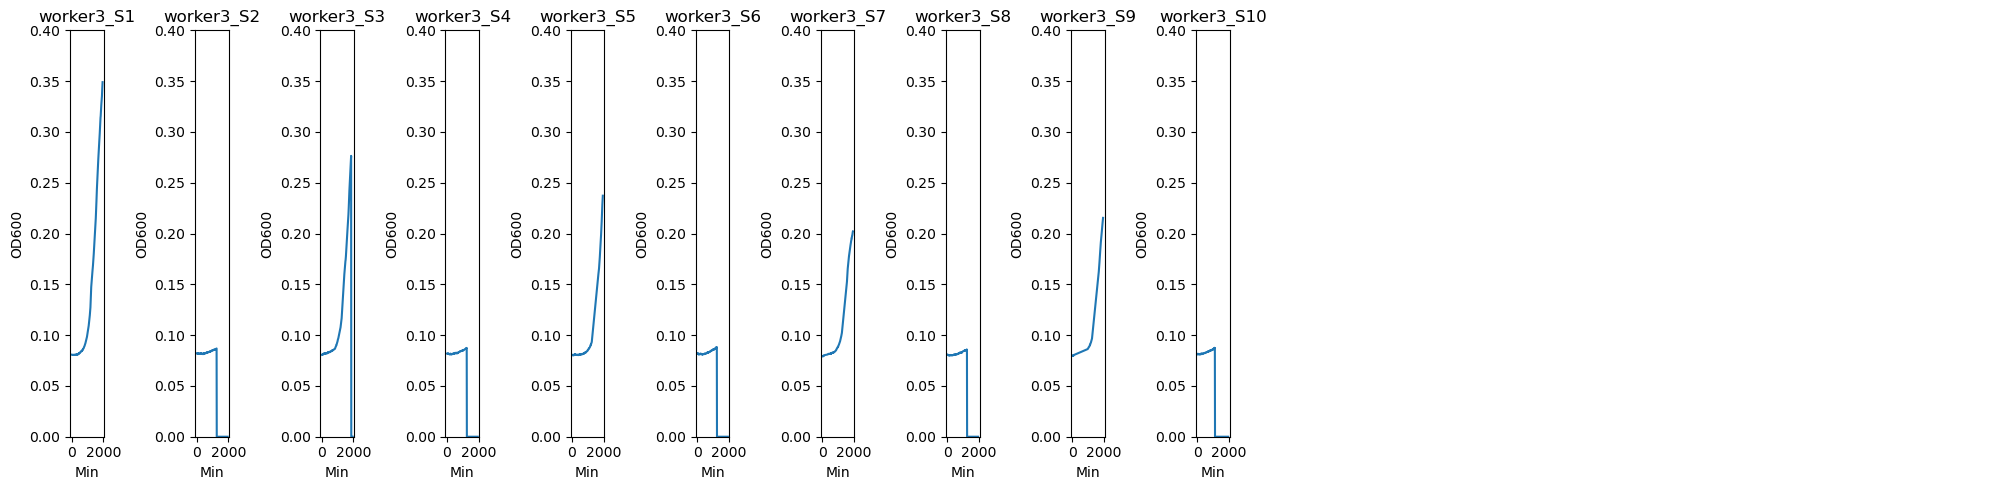

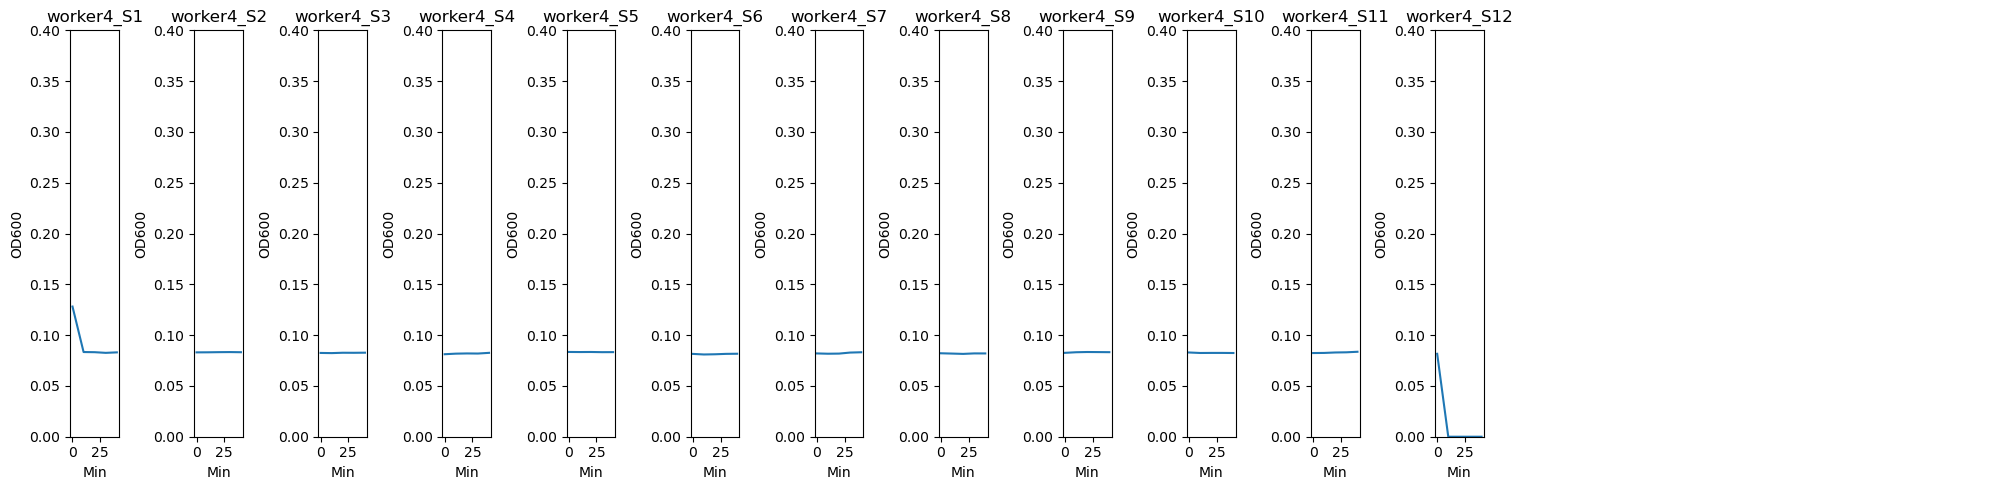

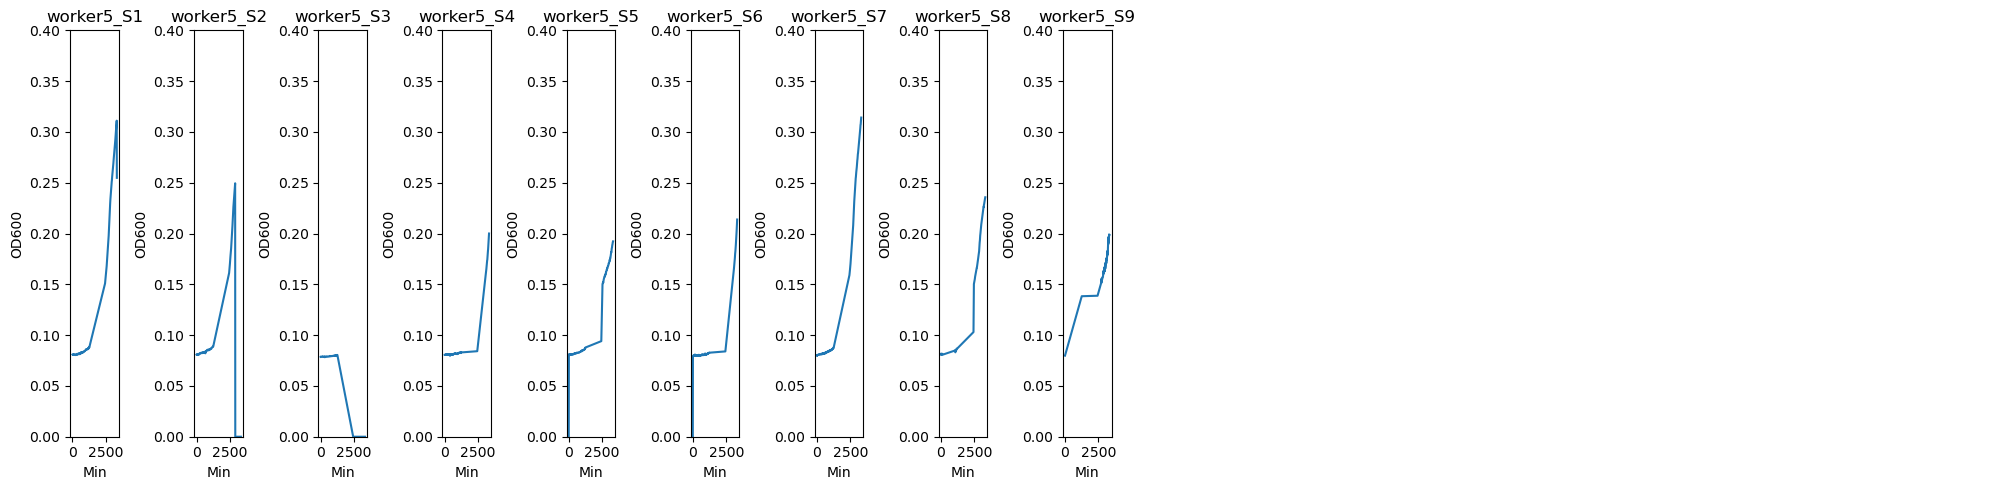

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import zipfile
import matplotlib.dates as mdates


def unzip_and_rename_csv(zip_file, extract_folder=None, new_name="latest_od_data.csv"):
    """
    Extracts a CSV from a ZIP file, renames it, and returns its path.
    """
    extract_folder = extract_folder or os.path.dirname(zip_file)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        csv_file = next((os.path.join(extract_folder, f) for f in zip_ref.namelist() if f.lower().endswith('.csv')), None)
    if not csv_file:
        raise FileNotFoundError("No CSV found in the ZIP.")
    renamed_path = os.path.join(extract_folder, new_name)
    os.rename(csv_file, renamed_path)
    return renamed_path


# Load the most recent CSV or extract from ZIP
csv_files = glob.glob(os.path.expanduser('~/Downloads/*.csv'))
latest_csv = max(csv_files, key=os.path.getmtime) if csv_files else unzip_and_rename_csv('./od_logs/latest_od_data.zip')
exp1_csv = unzip_and_rename_csv('./od_logs/exp1.zip', new_name="exp1.csv")

# Load and preprocess data
def preprocess_csv(file_path):
    """Load and preprocess CSV data."""
    return (
        pd.read_csv(file_path)
        .rename(columns={"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})
        .drop(columns=["experiment", "timestamp", "angle", "channel"])
        .assign(Time=lambda d: pd.to_datetime(d["Time"]))
    )

df = pd.concat([preprocess_csv(latest_csv), preprocess_csv(exp1_csv)])
df = df.drop_duplicates(subset=['Time', 'Unit'])  # Remove duplicates
df = df.pivot(index='Time', columns='Unit', values='OD600')  # Pivot for analysis

# Apply transformations
transformations = {
    'worker2': (1.3486, 0.077),
    'worker3': (2.0737, 0.077),
    'worker4': (2.2043, 0.077),
    'worker5': (1.1695, 0.077)
}

for unit, (slope, intercept) in transformations.items():
    if unit in df.columns:
        df[unit] = df[unit] * slope + intercept

# Filter out datapoints above .8
df = df[df < 0.45]


# Resample to 30min intervals and find points where the standard deviation is greater than 0.05
resampled_data = df.resample('30min').mean()
subculture_points_dict = {}

for unit in df.columns:
    unit_resample = resampled_data[unit]
    subculture_points = unit_resample.loc[unit_resample.rolling(3).std().abs() > 0.02]
    subculture_points = subculture_points.loc[subculture_points.groupby(subculture_points.index.date).idxmin()]
    subculture_points_dict[unit] = subculture_points

# Split each worker's data into separate DataFrames at their subculture points
splits_dict = {}

for unit, subculture_points in subculture_points_dict.items():
    unit_data = df[unit].resample('10min').mean()  # Resample to 10min
    splits = []
    previous_index = unit_data.index[0]
    
    for subculture_time in subculture_points.index:
        split_df = unit_data.loc[previous_index:subculture_time]
        splits.append(split_df)
        previous_index = subculture_time
    
    splits_dict[unit] = splits

# Set each section to start at T0 and display time as minutes elapsed
splits_elapsed_dict = {}

for unit, splits in splits_dict.items():
    elapsed_splits = []
    for split_df in splits:
        elapsed_time = (split_df.index - split_df.index[0]).total_seconds() / 60  # Convert to minutes
        split_df_elapsed = split_df.copy()
        split_df_elapsed.index = elapsed_time.astype(int)
        elapsed_splits.append(split_df_elapsed)
    splits_elapsed_dict[unit] = elapsed_splits

# Create a new DataFrame for each worker with split sections as columns
worker_dfs = {}

for unit, elapsed_splits in splits_elapsed_dict.items():
    unit_df = pd.DataFrame()
    for i, split_df_elapsed in enumerate(elapsed_splits):
        split_df_elapsed = split_df_elapsed[(split_df_elapsed.index <= 1250) | (split_df_elapsed > 0.15)]  # Keep points before 20 hours or above 0.15
        unit_df[f'{unit}_S{i+1}'] = split_df_elapsed
    unit_df.index.name = 'Min'
    worker_dfs[unit] = unit_df.interpolate(method='linear', limit_area='inside').fillna(0)

# Visualization

# Dynamic Subplot Creation
for unit, unit_df in worker_dfs.items():
    n_cols = 16  # Number of columns in the grid
    n_rows = -(-len(unit_df.columns) // n_cols)  # Calculate rows needed, round up with negative division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), squeeze=False)
    
    for i, (col, data) in enumerate(unit_df.items()):
        row, col_idx = divmod(i, n_cols)  # Determine the row and column for the current plot
        ax = axes[row, col_idx]
        data.plot(ax=ax, title=col)
        ax.set_xlabel('Min')
        ax.set_ylabel('OD600')
        ax.set_ylim(0, 0.4)
    
    # Hide unused subplots
    for r in range(n_rows):
        for c in range(n_cols):
            if r * n_cols + c >= len(unit_df.columns):
                axes[r, c].axis('off')
    
    plt.tight_layout()
    plt.show()


Time
2024-11-09 10:51:04    0.080733
2024-11-09 10:51:09    0.080557
2024-11-09 10:51:14    0.080185
2024-11-09 10:51:19    0.080089
2024-11-09 10:51:24    0.080004
                         ...   
2024-12-04 13:17:07         NaN
2024-12-04 13:22:07         NaN
2024-12-04 13:27:07    0.079877
2024-12-04 13:32:07    0.079719
2024-12-04 13:37:07    0.079996
Name: worker3, Length: 457770, dtype: float64

,55_S1,55_S2,55_S3,55_S4,55_S5,55_S6,55_S7,55_S8,55_S9,55_S10
Min,,,,,,,,,,
0,0.0807,0.0819,0.0807,0.0819,0.0802,0.0819,0.0792,0.0809,0.0796,0.0812
10,0.0807,0.0817,0.0808,0.0820,0.0803,0.0816,0.0790,0.0810,0.0797,0.0816
20,0.0806,0.0820,0.0807,0.0822,0.0804,0.0818,0.0791,0.0808,0.0798,0.0816
30,0.0806,0.0819,0.0805,0.0821,0.0805,0.0819,0.0793,0.0808,0.0798,0.0816
40,0.0806,0.0820,0.0811,0.0819,0.0807,0.0820,0.0792,0.0806,0.0800,0.0814
...,...,...,...,...,...,...,...,...,...,...
1860,0.3246,0.1032,NaN,0.1088,0.2049,0.1114,0.1952,0.1019,0.1999,NaN
1870,0.3268,0.1038,NaN,0.1086,0.2083,0.1117,0.1952,0.1021,0.2016,NaN
1880,0.3291,0.1045,NaN,0.1094,0.2121,0.1123,0.1962,0.1029,0.2037,NaN


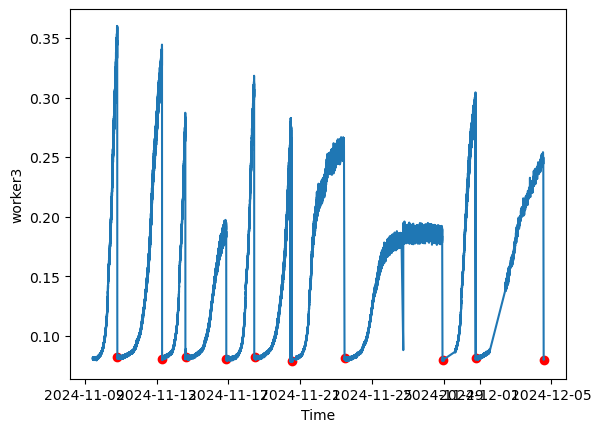

In [ ]:
w3 = df['worker3']

def df_transformations(df, exp_type)




display(w3)

# Resample to 30min intervals and find points where the standard deviation is greater than 0.05. Use 30min becuase it actually detects the steps.
w3_resample = w3.resample('30min').mean()

w3_subculture_points = w3_resample.loc[w3_resample.rolling(3).std().abs() > 0.02]
w3_subculture_points = w3_subculture_points.loc[w3_subculture_points.groupby(w3_subculture_points.index.date).idxmin()]

sns.lineplot(data=w3)
plt.scatter(w3_subculture_points.index, w3_subculture_points.values, color='red')

#Resample the actual dataframe for grme to 10 min intervals
w3 = w3.resample('10min').mean()

# Split w3 into separate dataframes at each w3_subculture_points timestamp
w3_splits = []
previous_index = w3.index[0]

for subculture_time in w3_subculture_points.index:
    split_df = w3.loc[previous_index:subculture_time]
    w3_splits.append(split_df)
    previous_index = subculture_time

# # Add the last segment
# w3_splits.append(w3.loc[previous_index:])

# Set each section to start at T0 and display time as minutes elapsed
w3_splits_elapsed = []

for split_df in w3_splits:
    elapsed_time = (split_df.index - split_df.index[0]).total_seconds() / 60  # Convert to minutes
    split_df_elapsed = split_df.copy()
    split_df_elapsed.index = elapsed_time.astype(int)
    w3_splits_elapsed.append(split_df_elapsed)

# Create a new DataFrame to hold the split sections
w3 = pd.DataFrame()

# Add each split section to its own column
for i, split_df_elapsed in enumerate(w3_splits_elapsed):
    split_df_elapsed = split_df_elapsed[split_df_elapsed.index <= (split_df_elapsed.index[-1] - 60)]  # Remove last hour
    w3[f'55_S{i+1}'] = split_df_elapsed


# Set the index to Minutes
w3.index.name = 'Min'
# w3.drop(['55_S3','55_S5'], axis=1, inplace=True)
w3 = w3.interpolate(method='linear', limit_area='inside').round(4)
# w3 = w3.fillna(0)

w3

,R1_S1,R1_S2,R1_S3,R1_S4,R1_S5,R1_S6,R1_S7,R1_S8,R1_S9,R1_S10
Minutes,,,,,,,,,,
0,0.0807,0.0819,0.0807,0.0819,0.0802,0.0819,0.0792,0.0809,0.0796,0.0812
10,0.0807,0.0817,0.0808,0.0820,0.0803,0.0816,0.0790,0.0810,0.0797,0.0816
20,0.0806,0.0820,0.0807,0.0822,0.0804,0.0818,0.0791,0.0808,0.0798,0.0816
30,0.0806,0.0819,0.0805,0.0821,0.0805,0.0819,0.0793,0.0808,0.0798,0.0816
40,0.0806,0.0820,0.0811,0.0819,0.0807,0.0820,0.0792,0.0806,0.0800,0.0814
...,...,...,...,...,...,...,...,...,...,...
1860,0.3246,0.1032,NaN,0.1088,0.2049,0.1114,0.1952,0.1019,0.1999,NaN
1870,0.3268,0.1038,NaN,0.1086,0.2083,0.1117,0.1952,0.1021,0.2016,NaN
1880,0.3291,0.1045,NaN,0.1094,0.2121,0.1123,0.1962,0.1029,0.2037,NaN


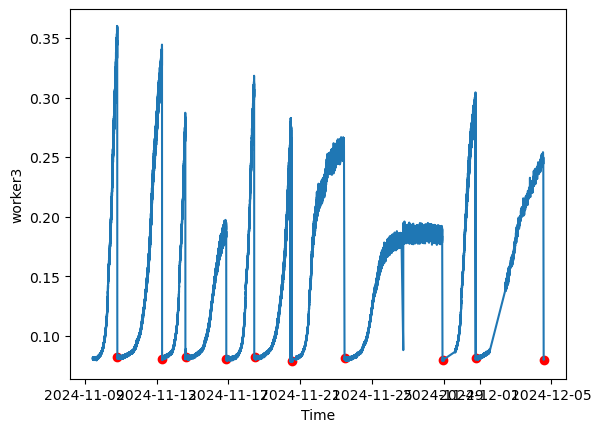

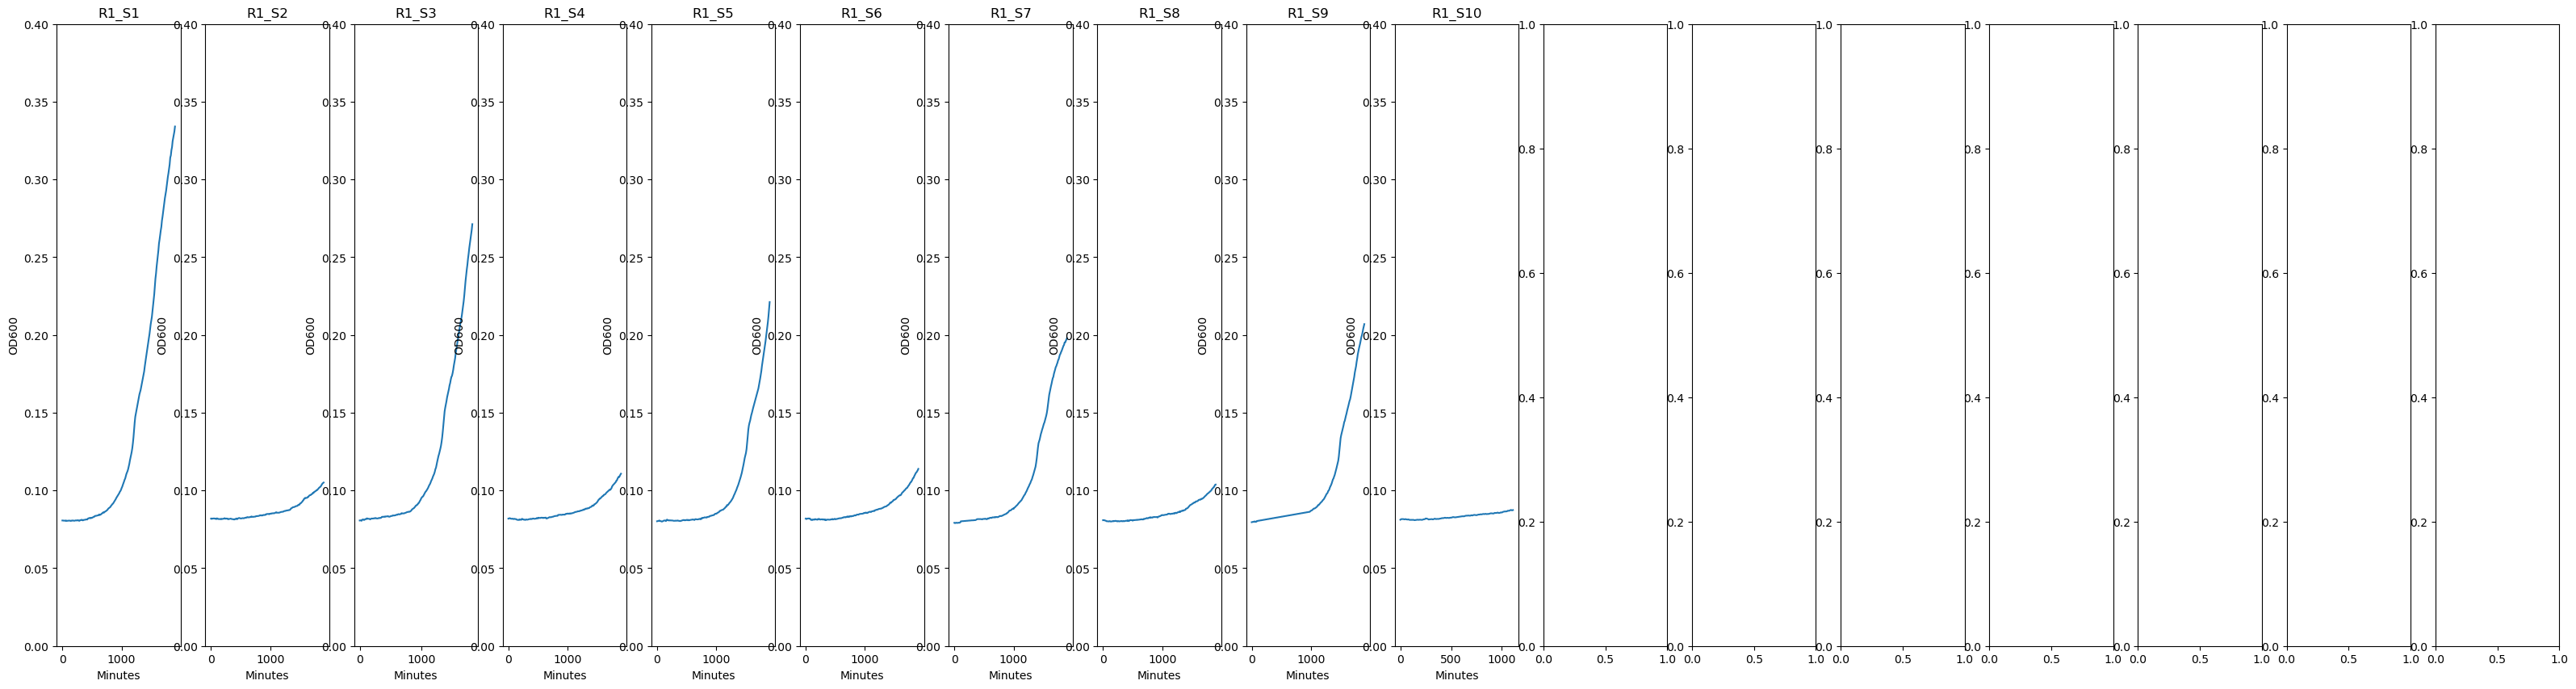

In [39]:
w3 = df['worker3']

# Resample to 30min intervals and find points where the standard deviation is greater than 0.05. Use 30min becuase it actually detects the steps.
w3_resample = w3.resample('30min').mean()

w3_subculture_points = w3_resample.loc[w3_resample.rolling(3).std().abs() > 0.02]
w3_subculture_points = w3_subculture_points.loc[w3_subculture_points.groupby(w3_subculture_points.index.date).idxmin()]

sns.lineplot(data=w3)
plt.scatter(w3_subculture_points.index, w3_subculture_points.values, color='red')

#Resample the actual dataframe for grme to 10 min intervals
w3 = w3.resample('10min').mean()

# Split w3 into separate dataframes at each w3_subculture_points timestamp
w3_splits = []
previous_index = w3.index[0]

for subculture_time in w3_subculture_points.index:
    split_df = w3.loc[previous_index:subculture_time]
    w3_splits.append(split_df)
    previous_index = subculture_time

# # Add the last segment
# w3_splits.append(w3.loc[previous_index:])

# Set each section to start at T0 and display time as minutes elapsed
w3_splits_elapsed = []

for split_df in w3_splits:
    elapsed_time = (split_df.index - split_df.index[0]).total_seconds() / 60  # Convert to minutes
    split_df_elapsed = split_df.copy()
    split_df_elapsed.index = elapsed_time.astype(int)
    w3_splits_elapsed.append(split_df_elapsed)

# Create a new DataFrame to hold the split sections
w3 = pd.DataFrame()

# Add each split section to its own column
for i, split_df_elapsed in enumerate(w3_splits_elapsed):
    split_df_elapsed = split_df_elapsed[split_df_elapsed.index <= (split_df_elapsed.index[-1] - 60)]  # Remove last hour
    w3[f'R1_S{i+1}'] = split_df_elapsed


# Set the index to Minutes
w3.index.name = 'Minutes'
w3 = w3.interpolate(method='linear', limit_area='inside').round(4)
# w3 = w3.fillna(0)

fig, axes = plt.subplots(1, 17, figsize=(40, 10))
for i, (col, data) in enumerate(w3.items()):
    data.plot(ax=axes[i], title=col)
    axes[i].set_xlabel('Minutes')
    axes[i].set_ylabel('OD600')
    axes[i].set_ylim(0, 0.4)

#export as a tabe delimited file
w3.to_csv('w3.txt', sep='\t')
w3